In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as ttf

import os
import os.path as osp

from tqdm import tqdm
from PIL import Image
from sklearn.metrics import roc_auc_score
import numpy as np
import math

# Brief note on the assignment

In this assignment I have trained two separate models both using ConvNeXt for the Classification and Verification tasks because the model (model-1) that produced highest accuracy for the Classification task (Private score: 0.86102) did not produce the best score on the Verification task (that produced private score of 0.95246 in verification task). The other model (model-2) produced private score of 0.96046 on verification task which was producing private score of 0.84816 on classification.

Model-1: Classification score - 0.86102; validation score - 0.95246

Model-2: Classification score - 0.84816; validation score - 0.96046

The weights of these two models are attached with the submission:

Model-1: epo_num_152_model_classification.pt

Model-2: epo_num_64_model_verification.pt

The code trains the first model and after producing predictions for the classification task, it trains the second model for producing predictions for the verification task.

InvertedResidualBlock is same for both the models while the configuration for the ConvNeXt class, number of epochs and data augmentation methods are different for the two.

Following are the main differences of the configurations of the two models:

Model-1:
batch_size = 250

lr = 0.05

epochs = 152

for the ConvNeXt class: 

in_channels = 32

size of the last linear layer, last_linear_layer = 550

nn.Dropout(p = 0.25)

train_transforms = [ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.RandAugment(),
                    ttf.GaussianBlur(kernel_size = 5),
                    ttf.ColorJitter(brightness = (0.5, 1.5), 
                                    contrast = (0.5, 1.5),
                                    saturation = (0, 0.5),
                                    hue = 0),
                    ttf.RandomAffine(degrees = 10),
                    ttf.ToTensor()]


Model-2:

batch_size = 128

lr = 0.05

epochs = 64

for the ConvNeXt class: 

in_channels = 32

size of the last linear layer, last_linear_layer = 512

nn.Dropout(p = 0.2)

train_transforms = [ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.ColorJitter(brightness = (0.6, 1.4), 
                                    contrast = (0.6, 1.4),
                                    saturation = (0, 0.5),
                                    hue = 0),
                    ttf.RandAugment(),
                    ttf.GaussianBlur(kernel_size = 7),
                    ttf.RandomAffine(degrees = 10),
                    ttf.ToTensor()]

However, both the models use the same configuration for expand_ratio, channels, blocks, stride of first block:
 [4,   96, 3, 2],
 [8,  192, 3, 2],
 [8,  384, 7, 2],
 [8,  512, 3, 2]

In the process of arriving at the above two models I have explored different combinations of values of the following hyperparameters and have included configurations that worked for my homework group team members. Surprisingly some of the configurations of the hyperparameter values that worked for other teammates did not produce similar good results in my case.

I have also mentioned these alternatives within the code.

batch_sizes: 32, 64, 128, 250

learning rates: 0.012, 0.0185, 0.01, 0.05

size of the last linear layer in ConvNeXt, last_linear_layer = tried 512, 550, 740, 750, 760

760 was the maximum size that would allow the number of parameters to be under 35MN for this configuration.

Data augmentation combinations tried other than the above two that worked:

config 1

train_transforms = [ttf.ColorJitter(brightness = 0.25, contrast = 0.25, saturation = 0.25, hue = 0.2),
                    ttf.RandomHorizontalFlip(p = 0.25),
                    ttf.RandomVerticalFlip(p = 0.25),
                    ttf.RandomAffine(degrees = 25, translate = None, scale = (0.6, 0.8)),
                    ttf.ToTensor()]


config 2

train_transforms = [ttf.RandomAffine(degrees = 5),
                    ttf.RandomApply(transforms = nn.ModuleList([ttf.ColorJitter()]), p = 0.5),
                    ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.RandomAdjustSharpness(sharpness_factor = 0, p = 0.5),
                    ttf.RandomAutocontrast(p = 0.5),
                    ttf.ToTensor()]


config 3

train_transforms = [ttf.RandomAffine(degrees = 5),
                    ttf.RandomApply(transforms = nn.ModuleList([ttf.ColorJitter(brightness = (0.6, 1.4), 
                                                                                contrast = (0.6, 1.4), 
                                                                                saturation = 0, 
                                                                                hue = 0)]), p = 0.5),
                    ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.RandomAdjustSharpness(sharpness_factor = 0, p = 0.5),
                    ttf.RandomAutocontrast(p = 0.5),
                    ttf.ToTensor()]

Alternative configurations for expand_ratio, channels, # blocks, stride of first block

alternative-2 considered
            [8,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]

alternative-3 considered
            [6,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]

I was using colab pro that crashes after certain epochs, so I have set up a system in which I can load the last saved model before crash and then continue the training thereon. This causes the train and validation accuracies to drop again and the recover to the earlier levels after a few epochs (20-30 epochs). However, the above two models were trained upto epoch 152 and 64 respectively in a single run without break.


Following is how the train and test accuracies for the classification task changed over the epochs for the two models:



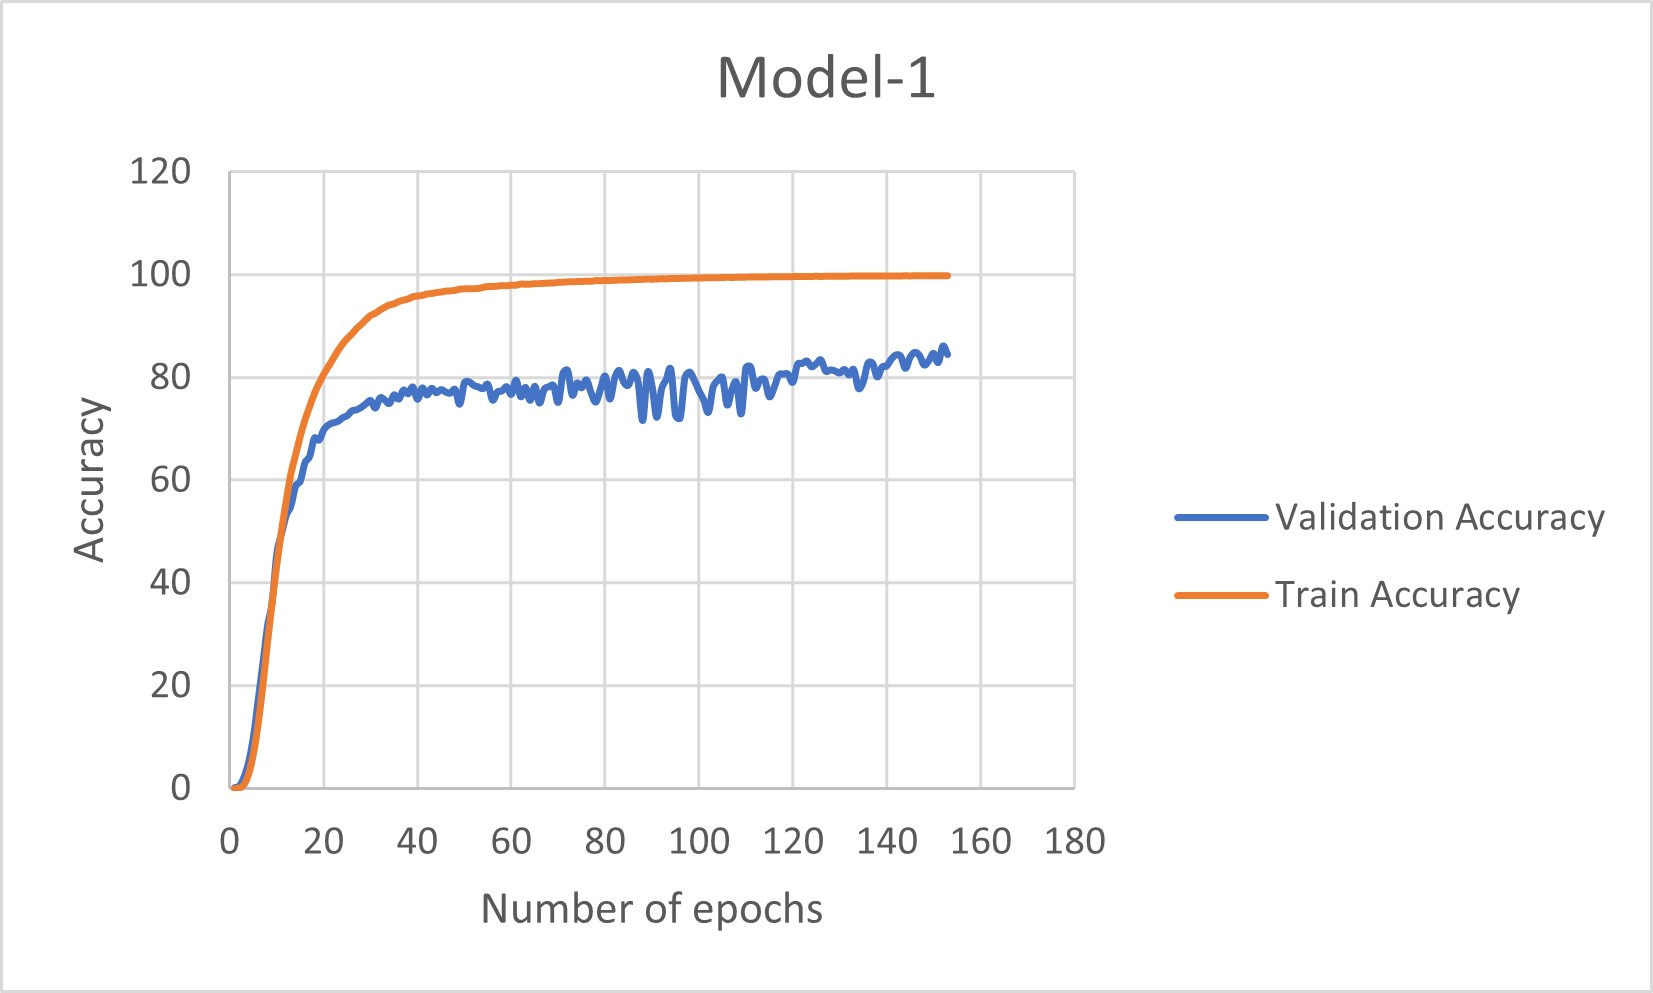

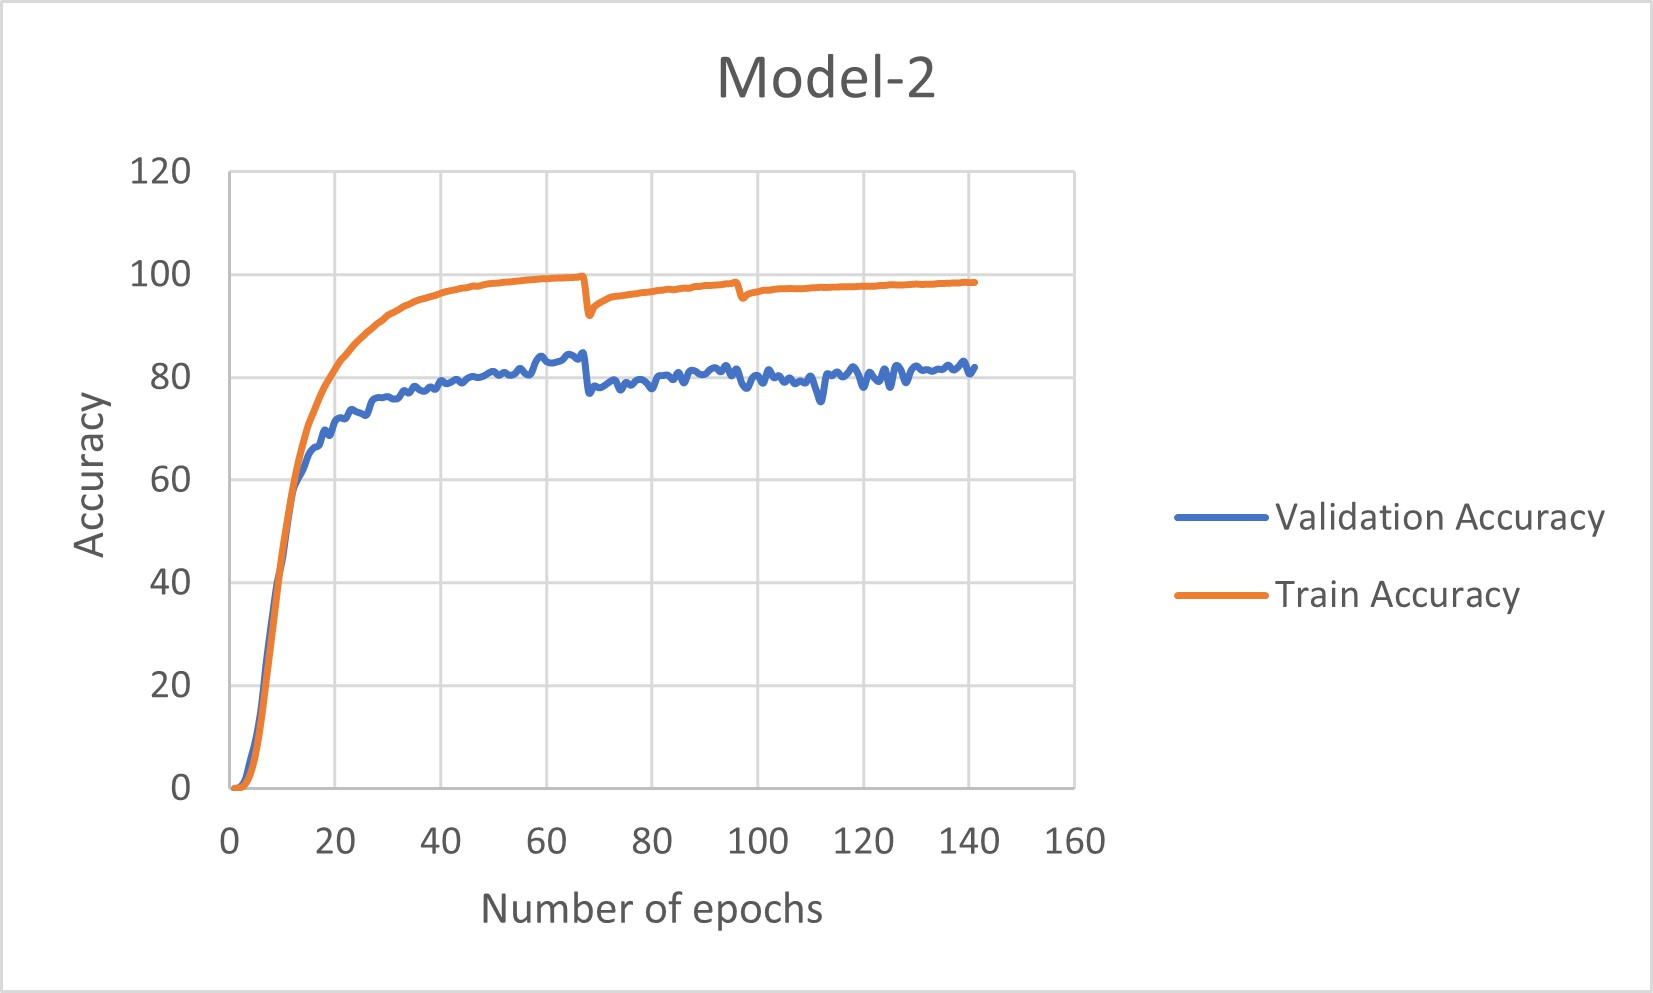

# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f: #/home/ubuntu/.kaggle/kaggle.json for running on AWS #/root/.kaggle/kaggle.json for colab
    f.write('{"username":"patelravi","key":"c1a7fea57eed01dfa744d9d6bb02a004"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle competitions download -c 11-785-s22-hw2p2-classification
!kaggle competitions download -c 11-785-s22-hw2p2-verification

!unzip -q 11-785-s22-hw2p2-classification.zip
!unzip -q 11-785-s22-hw2p2-verification.zip

!ls

11-785-s22-hw2p2-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
11-785-s22-hw2p2-verification.zip: Skipping, found more recently modified local copy (use --force to force download)
replace classification/classification/dev/n000002/0121_01.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
replace verification/verification/dev/000b28b024.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
11-785-s22-hw2p2-classification.zip   train_dataset_c4.pt
11-785-s22-hw2p2-verification.zip     train_subset
classification			      val_dataset_c4.pt
classification_sample_submission.csv  verification
epo_num_152_model_classification.pt   verification_sample_submission.csv
sample_data


# Hyperparameters

In [ ]:
"""
The well-accepted SGD batch_size & lr combination for CNN classification is 256 batch size for 0.1 learning rate.
When changing batch size for SGD, follow the linear scaling rule - halving batch size -> halve learning rate, etc.
This is less theoretically supported for Adam, but in my experience, it's a decent ballpark estimate.
"""

# classification task: batch size of 250 produced the highest accuracy for the classification task
# verification task: batch size of 128 produced the highest accuracy for the verification task

# for the classification task final model
batch_size = 250     #tried 32, 64, 128, 250

lr = 0.05         #tried 0.012, 0.0185, 0.01, 0.05
epochs = 200 # Just for the early submission. We'd want you to train like 50 epochs for your main submissions.

# Very Simple Network

In [ ]:
class Network(nn.Module):
    """
    The Very Low early deadline architecture is a 4-layer CNN.
    The first Conv layer has 64 channels, kernel size 7, and stride 4.
    The next three have 128, 256, and 512 channels. Each have kernel size 3 and stride 2.
    Think about what the padding should be for each layer to not change spatial resolution.
    Each Conv layer is accompanied by a Batchnorm and ReLU layer.
    Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1.
    Then, remove (Flatten?) these trivial 1x1 dimensions away.
    Look through https://pytorch.org/docs/stable/nn.html 
    TODO: Fill out the model definition below! 

    Why does a very simple network have 4 convolutions?
    Input images are 224x224. Note that each of these convolutions downsample.
    Downsampling 2x effectively doubles the receptive field, increasing the spatial
    region each pixel extracts features from. Downsampling 32x is standard
    for most image models.

    Why does a very simple network have high channel sizes?
    Every time you downsample 2x, you do 4x less computation (at same channel size).
    To maintain the same level of computation, you 2x increase # of channels, which 
    increases computation by 4x. So, balances out to same computation.
    Another intuition is - as you downsample, you lose spatial information. Want
    to preserve some of it in the channel dimension.
    """
    def __init__(self, num_classes=7000):
        super().__init__()

        self.backbone = nn.Sequential(
            # Note that first conv is stride 4. It is (was?) standard to downsample.
            # 4x early on, as with 224x224 images, 4x4 patches are just low-level details.
            # Food for thought: Why is the first conv kernel size 7, not kernel size 3?

            # TODO: Conv group 1
            # TODO: Conv group 2
            # TODO: Conv group 3
            # TODO: Conv group 4

            # TODO: Average pool over & reduce the spatial dimensions to (1, 1)
            # TODO: Collapse (Flatten) the trivial (1, 1) dimensions
            ) 
        
        self.cls_layer = nn.Linear(512, num_classes)
    
    def forward(self, x, return_feats=False):
        """
        What is return_feats? It essentially returns the second-to-last-layer
        features of a given image. It's a "feature encoding" of the input image,
        and you can use it for the verification task. You would use the outputs
        of the final classification layer for the classification task.

        You might also find that the classification outputs are sometimes better
        for verification too - try both.
        """
        feats = self.backbone(x)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out

In [ ]:
class InvertedResidualBlock_MobileNetV2(nn.Module):
    """
    Intuitively, layers in MobileNet can be split into "feature mixing" 
    and "spatial mixing" layers. You can think of feature mixing as each pixel
    "thinking on its own" about its own featuers, and you can think of spatial
    mixing as pixels "talking with each other". Alternating these two builds
    up a CNN.

    In a bit more detail:

    - The purpose of the "feature mixing" layers is what you've already seen in 
    hw1p2. Remember, in hw1p2, we went from some low-level audio input to
    semantically rich representations of phonemes. Featuring mixing is simply a 
    linear layer (a weight matrix) that transforms simpler features into 
    something more advanced.

    - The purpose of the "spatial mixing" layers is to mix features from different
    spatial locations. You can't figure out a face by looking at each pixel on
    its own, right? So we need 3x3 convolutions to mix features from neighboring
    pixels to build up spatially larger features.
    """
    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 expand_ratio):
        super().__init__() # Just have to do this for all nn.Module classes

        # Can only do identity residual connection if input & output are the
        # same channel & spatial shape.
        if stride == 1 and in_channels == out_channels:
            self.do_identity = True
        else:
            self.do_identity = False
        
        # Expand Ratio is like 6, so hidden_dim >> in_channels
        hidden_dim = in_channels * expand_ratio

        """
        What is this doing? It's a 1x1 convolutional layer that drastically
        increases the # of channels (feature dimension). 1x1 means each pixel
        is thinking on its own, and increasing # of channels means the network
        is seeing if it can "see" more clearly in a higher dimensional space.

        Some patterns are just more obvious/separable in higher dimensions.

        Also, note that bias = False since BatchNorm2d has a bias term built-in.

        As you go, note the relationship between kernel_size and padding. As you
        covered in class, padding = kernel_size // 2 (kernel_size being odd) to
        make sure input & output spatial resolution is the same.
        """
        self.feature_mixing = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(in_channels, hidden_dim, kernel_size = 1, stride = 1, padding = 0, bias = False), # bias = False, True if no BatchNorm2d
            nn.BatchNorm2d(hidden_dim),
            nn.GELU() # ReLU6, GELU
        )

        """
        What is this doing? Let's break it down.
        - kernel_size = 3 means neighboring pixels are talking with each other.
          This is different from feature mixing, where kernel_size = 1.

        - stride. Remember that we sometimes want to downsample spatially. 
          Downsampling is done to reduce # of pixels (less computation to do), 
          and also to increase receptive field (if a face was 32x32, and now
          it's 16x16, a 3x3 convolution covers more of the face, right?). It
          makes sense to put the downsampling in the spatial mixing portion
          since this layer is "in charge" of messing around spatially anyway.

          Note that most of the time, stride is 1. It's just the first block of
          every "stage" (layer \subsetof block \subsetof stage) that we have
          stride = 2.

        - groups = hidden_dim. Remember depthwise separable convolutions in 
          class? If not, it's fine. Usually, when we go from hidden_dim channels
          to hidden_dim channels, they're densely connected (like a linear 
          layer). So you can think of every pixel/grid in an input
          3 x 3 x hidden_dim block being connected to every single pixel/grid 
          in the output 3 x 3 x hidden_dim block.
          What groups = hidden_dim does is remove a lot of these connections.

          Now, each input 3 x 3 block/region is densely connected to the
          corresponding output 3 x 3 block/region. This happens for each of the
          hidden_dim input/output channel pairs independently.
          So we're not even mixing different channels together - we're only 
          mixing spatial neighborhoods. 
          
          Try to draw this out, or come to my (Jinhyung Park)'s OH if you want 
          a more in-depth explanation.
          https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
        """
        self.spatial_mixing = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(hidden_dim, hidden_dim, 
                      kernel_size = 3, padding = 1, 
                      stride = stride, groups = hidden_dim, bias = False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(),
        )

        """
        What's this? Remember that hidden_dim is quite large - six times the 
        in_channels. So it was nice to do the above operations in this high-dim
        space, where some patterns might be more clear. But we still want to 
        bring it back down-to-earth.

        Intuitively, you can takeaway two reasons for doing this:
        - Reduces computational cost by a lot. 6x in & out channels means 36x
          larger weights, which is crazy. We're okay with just one of input or 
          output of a convolutional layer being large when mixing channels, but 
          not both.
        
        - We also want a residual connection from the input to the output. To 
          do that without introducing another convolutional layer, we want to
          condense the # of channels back to be the same as the in_channels.
          (out_channels and in_channels are usually the same).
        """
        self.bottleneck_channels = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(hidden_dim, out_channels, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        out = self.feature_mixing(x)
        out = self.spatial_mixing(out)
        out = self.bottleneck_channels(out)

        if self.do_identity:
            return x + out
        else:
            return out


In [ ]:
class MobileNetV2(nn.Module):
    """
    The heavy lifting is already done in InvertedBottleneck.

    Why MobileNetV2 and not V3? V2 is the foundation for V3, which uses "neural
    architecture search" to find better configurations of V2. If you understand
    V2 well, you can totally implement V3!
    """
    def __init__(self, num_classes= 7000):
        super().__init__()

        self.num_classes = num_classes

        """
        First couple of layers are special, just do them here.
        This is called the "stem". Usually, methods use it to downsample or twice.
        """
        self.stem = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(3, 32, kernel_size = 3, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1, groups = 32, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU6(),
            nn.Conv2d(32, 16, kernel_size = 1, stride = 1, padding = 0, bias = False),
            nn.BatchNorm2d(16),
        )

        """
        Since we're just repeating InvertedResidualBlocks again and again, we
        want to specify their parameters like this.
        The four numbers in each row (a stage) are shown below.
        - Expand ratio: We talked about this in InvertedResidualBlock
        - Channels: This specifies the channel size before expansion
        - # blocks: Each stage has many blocks, how many?
        - Stride of first block: For some stages, we want to downsample. In a
          downsampling stage, we set the first block in that stage to have
          stride = 2, and the rest just have stride = 1.

        Again, note that almost every stage here is downsampling! By the time
        we get to the last stage, what is the image resolution? Can it still
        be called an image for our dataset? Think about this, and make changes
        as you want.
        """
        self.stage_cfgs = [
            # expand_ratio, channels, # blocks, stride of first block
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # Remember that our stem left us off at 16 channels. We're going to 
        # keep updating this in_channels variable as we go
        in_channels = 16

        # Let's make the layers
        layers = []
        for curr_stage in self.stage_cfgs:
            expand_ratio, num_channels, num_blocks, stride = curr_stage
            
            for block_idx in range(num_blocks):
                out_channels = num_channels
                layers.append(InvertedResidualBlock_MobileNetV2(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    # only have non-trivial stride if first block
                    stride=stride if block_idx == 0 else 1, 
                    expand_ratio=expand_ratio
                ))
                # In channels of the next block is the out_channels of the current one
                in_channels = out_channels 
            
        self.layers = nn.Sequential(*layers) # Done, save them to the class

        # Some final feature mixing
        self.final_block = nn.Sequential(
            nn.Conv2d(in_channels, 1280, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(1280),
            nn.ReLU6()
        )

        # Now, we need to build the final classification layer.
        self.cls_layer = nn.Sequential(
            # TODO: Fill this in!
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(1280, num_classes)
            # Pool over & collapse the spatial dimensions to (1, 1)
            # Collapse the trivial (1, 1) dimensions
            # Project to our # of classes
        )

        self._initialize_weights()

    def _initialize_weights(self):
        """
        Usually, I like to use default pytorch initialization for stuff, but
        MobileNetV2 made a point of putting in some custom ones, so let's just
        use them.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.stem(x)
        out = self.layers(out)
        out = self.final_block(out)
        out = self.cls_layer(out)

        return out

In [ ]:
class InvertedResidualBlock_Convnext(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 expand_ratio):
        super().__init__() # Just have to do this for all nn.Module classes

        # Can only do identity residual connection if input & output are the
        # same channel & spatial shape.
        if stride == 1 and in_channels == out_channels:
            self.do_identity = True
        else:
            self.do_identity = False
        
        # Expand Ratio is like 6, so hidden_dim >> in_channels
        hidden_dim = in_channels * expand_ratio

        self.spatial_mixing = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(in_channels, in_channels, 
                      kernel_size = 7, 
                      padding = 7//2, 
                      stride = stride, 
                      groups = in_channels, 
                      bias = False), # bias = False, True if no BatchNorm2d
            nn.BatchNorm2d(in_channels)
        )

        self.feature_mixing = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(in_channels, hidden_dim, 
                      kernel_size = 1, 
                      stride = 1, 
                      padding = 1//2, # tried 1//2, 0
                      bias = True), # bias = False, True if no BatchNorm2d
            nn.GELU() # ReLU6, GELU
        )


        self.bottleneck_channels = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(hidden_dim, out_channels, 
                      kernel_size = 1, 
                      stride = 1, 
                      padding = 0, 
                      bias = True) # bias = False, True if no BatchNorm2d
        )

    def forward(self, x):
        out_spatial_mixing = self.spatial_mixing(x)
        out_feature_mixing = self.feature_mixing(out_spatial_mixing)
        out_bottleneck_channels = self.bottleneck_channels(out_feature_mixing)

        if self.do_identity:
            return x + out_bottleneck_channels
        else:
            return out_bottleneck_channels


In [ ]:
class ConvNeXt(nn.Module):

    def __init__(self, num_classes = 7000):
        super().__init__()

        in_channels = 32

        num_out_channels = 1280

        last_linear_layer = 550 # tried 512, 550, 740, 750, 760

        # last_linear_layer: to reduce the number of parameters below 35M, I tried the max number of out_features possible keeping total parameters under 35MN (which is 760 out_features) 
        # 740 out_features could not produce test accuracy more than 61% under config 1
        # 512 and 550 achieved much higher accuracies than the other higher sizes (740, 750, 760) of last linear layer

        self.num_classes = num_classes

        self.stem = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(3, in_channels, 
                      kernel_size = 3, 
                      stride = 2, 
                      padding = 3//2, 
                      bias = False),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
            )

        # alternative-1 considered
        self.stage_cfgs = [
            # expand_ratio, channels, # blocks, stride of first block
            [4,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]
            ]
            
        """ 
        alternative-2 considered
            [8,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]
        """

        """
        alternative-3 considered
            [6,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]
        """


        # Let's make the layers
        layers = []
        for curr_stage in self.stage_cfgs:
            expand_ratio, num_channels, num_blocks, stride = curr_stage
            
            for block_idx in range(num_blocks):
                out_channels = num_channels
                layers.append(InvertedResidualBlock_Convnext(
                    in_channels = in_channels,
                    out_channels = out_channels,
                    # only have non-trivial stride if first block
                    stride = stride if block_idx == 0 else 1, 
                    expand_ratio = expand_ratio
                ))
                # In channels of the next block is the out_channels of the current one
                in_channels = out_channels
            
        self.layers = nn.Sequential(*layers) # Done, save them to the class


        # Some final feature mixing
        self.final_block = nn.Sequential(
            nn.Conv2d(in_channels, 
                      num_out_channels, 
                      kernel_size = 1, 
                      padding = 0, 
                      stride = 1, 
                      bias = False),
            nn.BatchNorm2d(num_out_channels),
            nn.GELU(), # options: ReLU6, GELU
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            )
        
        # Now, we need to build the final classification layer.
        self.cls_layer = nn.Sequential(
            # TODO: Fill this in!
            nn.Linear(num_out_channels, last_linear_layer),
            nn.BatchNorm1d(last_linear_layer),                  # tried with nn.GELU() as well instead of nn.BatchNorm1d() and nn.ReLU6()
            nn.GELU(),                                          # tried ReLU, ReLU6, GELU #review
            nn.Dropout(p = 0.25),                               # 0.2, 0.25
            nn.Linear(last_linear_layer, self.num_classes)
            )

        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        stem_out = self.stem(x)
        layers_out = self.layers(stem_out)
        feat_out = self.final_block(layers_out)
        out = self.cls_layer(feat_out)
        return out




# Dataset & DataLoader

In [ ]:
"""
Transforms (data augmentation) is quite important for this task.
Go explore https://pytorch.org/vision/stable/transforms.html for more details
"""


DATA_DIR = "/content"  # for colab "/content" # for AWS "/home/ubuntu"
TRAIN_DIR = osp.join(DATA_DIR, "classification/classification/train") 
    # This is a smaller subset of the data. Should change this to classification/classification/train
    # small dataset: train_subset/train_subset
VAL_DIR = osp.join(DATA_DIR, "classification/classification/dev")
TEST_DIR = osp.join(DATA_DIR, "classification/classification/test")



# classification task
# config 4 - Used to train the final version of the model for classification task

train_transforms = [ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.RandAugment(),
                    ttf.GaussianBlur(kernel_size = 5),
                    ttf.ColorJitter(brightness = (0.5, 1.5), 
                                    contrast = (0.5, 1.5),
                                    saturation = (0, 0.5),
                                    hue = 0),
                    ttf.RandomAffine(degrees = 10),
                    ttf.ToTensor()]



""" other configurations tried

# config 1
train_transforms = [ttf.ColorJitter(brightness = 0.25, contrast = 0.25, saturation = 0.25, hue = 0.2),
                    ttf.RandomHorizontalFlip(p = 0.25),
                    ttf.RandomVerticalFlip(p = 0.25),
                    #ttf.RandomAutocontrast(),
                    ttf.RandomAffine(degrees = 25, translate = None, scale = (0.6, 0.8)),
                    ttf.ToTensor()]

                    # ttf.CenterCrop(), ttf.Resize(), ttf.RandomAutocontrast(), ttf.RandomEqualize(), ttf.RandomHorizontalFlip(), ttf.RandAugment(),ttf.ToTensor(),ttf.Normalize()


# config 2
train_transforms = [ttf.RandomAffine(degrees = 5),
                    ttf.RandomApply(transforms = nn.ModuleList([ttf.ColorJitter()]), p = 0.5),
                    ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.RandomAdjustSharpness(sharpness_factor = 0, p = 0.5),
                    #ttf.RandomVerticalFlip(),
                    ttf.RandomAutocontrast(p = 0.5),
                    #ttf.RandomAffine(degrees = 45, translate = None, scale = (0.8, 1.2)),
                    ttf.ToTensor()]


# config 3
train_transforms = [ttf.RandomAffine(degrees = 5),
                    ttf.RandomApply(transforms = nn.ModuleList([ttf.ColorJitter(brightness = (0.6, 1.4), 
                                                                                contrast = (0.6, 1.4), 
                                                                                saturation = 0, 
                                                                                hue = 0)]), p = 0.5),
                    ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.RandomAdjustSharpness(sharpness_factor = 0, p = 0.5),
                    #ttf.RandomVerticalFlip(),
                    ttf.RandomAutocontrast(p = 0.5),
                    #ttf.RandomAffine(degrees = 45, translate = None, scale = (0.8, 1.2)),
                    ttf.ToTensor()]

"""



val_transforms = [ttf.ToTensor()]

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = ttf.Compose(train_transforms))

val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=ttf.Compose(val_transforms))


# save the tensors locally to use the same augmented data again

torch.save(train_dataset, 'train_dataset_c4.pt')
torch.save(val_dataset, 'val_dataset_c4.pt')



In [ ]:

# loading dataset from saved imagefolder object

#train_dataset = torch.load('train_dataset_c4.pt')

#val_dataset = torch.load('val_dataset_c4.pt')


train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size,
                          shuffle = True, 
                          drop_last = True, 
                          num_workers = 4)

val_loader = DataLoader(val_dataset, 
                        batch_size = batch_size, 
                        shuffle = False,
                        drop_last = True, 
                        num_workers = 4)

# Setup everything for training

In [ ]:
model = ConvNeXt()
model.cuda()

# For this homework, we're limiting you to 35 million trainable parameters, as
# outputted by this. This is to help constrain your search space and maintain
# reasonable training times & expectations
num_trainable_parameters = 0
for p in model.parameters():
    num_trainable_parameters += p.numel()
print("Number of Params: {}".format(num_trainable_parameters))

# TODO: What criterion do we use for this task?
criterion = nn.CrossEntropyLoss(label_smoothing = 0.15) # 0.1, 0.15
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
# T_max is "how many times will i call scheduler.step() until it reaches 0 lr?"

# For this homework, we strongly strongly recommend using FP16 to speed up training.
# It helps more for larger models.
# Go to https://effectivemachinelearning.com/PyTorch/8._Faster_training_with_mixed_precision
# and compare "Single precision training" section with "Mixed precision training" section
scaler = torch.cuda.amp.GradScaler()

Number of Params: 33243866


# Let's train!

In [ ]:

for epoch in range(0, epochs): # upload_epoch_num or 0
    
    model.train(mode=True)
    
    # Quality of life tip: leave=False and position=0 are needed to make tqdm usable in jupyter
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    num_correct = 0
    total_loss = 0

    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.cuda()

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        with torch.cuda.amp.autocast():     
            outputs = model(x)
            loss = criterion(outputs, y)

        # Update # correct & loss as we go
        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # Another couple things you need for FP16. 
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        scheduler.step() # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # You need this to close the tqdm bar
    
    # saving the model
    torch.save(model, "epo_num_" + str(epoch + 1) + "_model.pt")

    #to download a local copy of the saved model in colab
    #from google.colab import files
    #files.download("epo_num_" + str(epoch+1) + "_model.pt")

    
    # validation accuracy
    model.eval()
    num_correct_validation = 0

    for i, (x, y) in enumerate(val_loader):
        x = x.cuda()
        y = y.cuda()
        with torch.no_grad():
            outputs_validation = model(x)
        num_correct_validation += int((torch.argmax(outputs_validation, axis=1) == y).sum())

    validation_accuracy = 100 * num_correct_validation / len(val_dataset)

    train_accuracy = 100 * num_correct / (len(train_loader) * batch_size)

    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.04f}, Validation Acc {:.04f}%".format(epoch + 1,
                                                                                                                       epochs,
                                                                                                                       train_accuracy,
                                                                                                                       float(total_loss / len(train_loader)),
                                                                                                                       float(optimizer.param_groups[0]['lr']),
                                                                                                                       validation_accuracy
                                                                                                                       ))
    if validation_accuracy > 86:
        break

# I have intentionally included the output values of the classification task training process for reference


Epoch 1/200: Train Acc 0.0100%, Train Loss 8.8127, Learning Rate 0.0500, Validation Acc 0.0600%


Epoch 2/200: Train Acc 0.1400%, Train Loss 8.4224, Learning Rate 0.0500, Validation Acc 0.4000%


Epoch 3/200: Train Acc 0.7957%, Train Loss 7.7133, Learning Rate 0.0500, Validation Acc 2.0857%


Epoch 4/200: Train Acc 2.8993%, Train Loss 7.0740, Learning Rate 0.0500, Validation Acc 5.0914%


Epoch 5/200: Train Acc 6.7564%, Train Loss 6.5201, Learning Rate 0.0499, Validation Acc 9.9086%


Epoch 6/200: Train Acc 12.5036%, Train Loss 6.0245, Learning Rate 0.0499, Validation Acc 16.9771%


Epoch 7/200: Train Acc 20.0007%, Train Loss 5.5541, Learning Rate 0.0498, Validation Acc 24.0629%


Epoch 8/200: Train Acc 28.3329%, Train Loss 5.1129, Learning Rate 0.0498, Validation Acc 31.4686%


Epoch 9/200: Train Acc 36.3029%, Train Loss 4.7339, Learning Rate 0.0498, Validation Acc 36.2114%


Epoch 10/200: Train Acc 43.6200%, Train Loss 4.4091, Learning Rate 0.0497, Validation Acc 45.6714%


Epoch 11/200: Train Acc 50.2921%, Train Loss 4.1338, Learning Rate 0.0496, Validation Acc 49.5571%


Epoch 12/200: Train Acc 56.0321%, Train Loss 3.8987, Learning Rate 0.0496, Validation Acc 53.1029%


Epoch 13/200: Train Acc 61.2950%, Train Loss 3.6953, Learning Rate 0.0495, Validation Acc 54.9571%


Epoch 14/200: Train Acc 64.9893%, Train Loss 3.5358, Learning Rate 0.0494, Validation Acc 58.8343%


Epoch 15/200: Train Acc 68.6493%, Train Loss 3.3922, Learning Rate 0.0493, Validation Acc 59.7886%


Epoch 16/200: Train Acc 71.8043%, Train Loss 3.2706, Learning Rate 0.0492, Validation Acc 63.3629%


Epoch 17/200: Train Acc 74.4064%, Train Loss 3.1635, Learning Rate 0.0491, Validation Acc 64.6143%


Epoch 18/200: Train Acc 76.9107%, Train Loss 3.0658, Learning Rate 0.0490, Validation Acc 68.1629%


Epoch 19/200: Train Acc 78.9621%, Train Loss 2.9877, Learning Rate 0.0489, Validation Acc 67.7686%


Epoch 20/200: Train Acc 80.7164%, Train Loss 2.9112, Learning Rate 0.0488, Validation Acc 69.7543%


Epoch 21/200: Train Acc 82.2043%, Train Loss 2.8501, Learning Rate 0.0487, Validation Acc 70.7486%


Epoch 22/200: Train Acc 83.7243%, Train Loss 2.7891, Learning Rate 0.0485, Validation Acc 71.1429%


Epoch 23/200: Train Acc 85.2600%, Train Loss 2.7288, Learning Rate 0.0484, Validation Acc 71.4114%


Epoch 24/200: Train Acc 86.5886%, Train Loss 2.6751, Learning Rate 0.0482, Validation Acc 72.1343%


Epoch 25/200: Train Acc 87.6543%, Train Loss 2.6320, Learning Rate 0.0481, Validation Acc 72.5400%


Epoch 26/200: Train Acc 88.5436%, Train Loss 2.5970, Learning Rate 0.0479, Validation Acc 73.4743%


Epoch 27/200: Train Acc 89.6214%, Train Loss 2.5562, Learning Rate 0.0478, Validation Acc 73.6686%


Epoch 28/200: Train Acc 90.4200%, Train Loss 2.5224, Learning Rate 0.0476, Validation Acc 74.1543%


Epoch 29/200: Train Acc 91.3493%, Train Loss 2.4924, Learning Rate 0.0475, Validation Acc 74.8686%


Epoch 30/200: Train Acc 92.1621%, Train Loss 2.4599, Learning Rate 0.0473, Validation Acc 75.4800%


Epoch 31/200: Train Acc 92.5821%, Train Loss 2.4419, Learning Rate 0.0471, Validation Acc 74.0314%


Epoch 32/200: Train Acc 93.2200%, Train Loss 2.4164, Learning Rate 0.0469, Validation Acc 76.0171%


Epoch 33/200: Train Acc 93.7350%, Train Loss 2.3931, Learning Rate 0.0467, Validation Acc 75.5971%


Epoch 34/200: Train Acc 94.2086%, Train Loss 2.3775, Learning Rate 0.0465, Validation Acc 74.8971%


Epoch 35/200: Train Acc 94.3971%, Train Loss 2.3673, Learning Rate 0.0463, Validation Acc 76.6057%


Epoch 36/200: Train Acc 94.8671%, Train Loss 2.3461, Learning Rate 0.0461, Validation Acc 75.7571%


Epoch 37/200: Train Acc 95.1350%, Train Loss 2.3334, Learning Rate 0.0459, Validation Acc 77.5314%


Epoch 38/200: Train Acc 95.3479%, Train Loss 2.3241, Learning Rate 0.0457, Validation Acc 76.8029%


Epoch 39/200: Train Acc 95.8043%, Train Loss 2.3045, Learning Rate 0.0455, Validation Acc 78.1371%


Epoch 40/200: Train Acc 95.9450%, Train Loss 2.2967, Learning Rate 0.0452, Validation Acc 75.7400%


Epoch 41/200: Train Acc 96.0543%, Train Loss 2.2913, Learning Rate 0.0450, Validation Acc 77.9600%


Epoch 42/200: Train Acc 96.3357%, Train Loss 2.2793, Learning Rate 0.0448, Validation Acc 76.5657%


Epoch 43/200: Train Acc 96.4214%, Train Loss 2.2714, Learning Rate 0.0445, Validation Acc 77.8657%


Epoch 44/200: Train Acc 96.6036%, Train Loss 2.2606, Learning Rate 0.0443, Validation Acc 77.0143%


Epoch 45/200: Train Acc 96.7193%, Train Loss 2.2543, Learning Rate 0.0440, Validation Acc 77.6229%


Epoch 46/200: Train Acc 96.8800%, Train Loss 2.2470, Learning Rate 0.0438, Validation Acc 77.1514%


Epoch 47/200: Train Acc 96.9386%, Train Loss 2.2413, Learning Rate 0.0435, Validation Acc 76.9286%


Epoch 48/200: Train Acc 97.0314%, Train Loss 2.2334, Learning Rate 0.0432, Validation Acc 77.6429%


Epoch 49/200: Train Acc 97.2857%, Train Loss 2.2255, Learning Rate 0.0430, Validation Acc 74.7743%


Epoch 50/200: Train Acc 97.3364%, Train Loss 2.2191, Learning Rate 0.0427, Validation Acc 79.0029%


Epoch 51/200: Train Acc 97.3207%, Train Loss 2.2176, Learning Rate 0.0424, Validation Acc 79.1171%


Epoch 52/200: Train Acc 97.3771%, Train Loss 2.2138, Learning Rate 0.0421, Validation Acc 78.4257%


Epoch 53/200: Train Acc 97.3914%, Train Loss 2.2082, Learning Rate 0.0418, Validation Acc 78.1314%


Epoch 54/200: Train Acc 97.6486%, Train Loss 2.1996, Learning Rate 0.0415, Validation Acc 77.8057%


Epoch 55/200: Train Acc 97.7850%, Train Loss 2.1927, Learning Rate 0.0412, Validation Acc 78.6286%


Epoch 56/200: Train Acc 97.7821%, Train Loss 2.1886, Learning Rate 0.0409, Validation Acc 75.5486%


Epoch 57/200: Train Acc 97.8586%, Train Loss 2.1839, Learning Rate 0.0406, Validation Acc 77.1457%


Epoch 58/200: Train Acc 97.9714%, Train Loss 2.1764, Learning Rate 0.0403, Validation Acc 77.3514%


Epoch 59/200: Train Acc 97.9229%, Train Loss 2.1766, Learning Rate 0.0400, Validation Acc 78.1800%


Epoch 60/200: Train Acc 98.0700%, Train Loss 2.1695, Learning Rate 0.0397, Validation Acc 76.6714%


Epoch 61/200: Train Acc 98.0279%, Train Loss 2.1695, Learning Rate 0.0394, Validation Acc 79.4571%


Epoch 62/200: Train Acc 98.2721%, Train Loss 2.1597, Learning Rate 0.0391, Validation Acc 76.2000%


Epoch 63/200: Train Acc 98.2171%, Train Loss 2.1576, Learning Rate 0.0387, Validation Acc 78.0600%


Epoch 64/200: Train Acc 98.2421%, Train Loss 2.1537, Learning Rate 0.0384, Validation Acc 75.5143%


Epoch 65/200: Train Acc 98.3407%, Train Loss 2.1491, Learning Rate 0.0381, Validation Acc 78.2714%


Epoch 66/200: Train Acc 98.3414%, Train Loss 2.1459, Learning Rate 0.0377, Validation Acc 74.9886%


Epoch 67/200: Train Acc 98.4114%, Train Loss 2.1417, Learning Rate 0.0374, Validation Acc 77.6857%


Epoch 68/200: Train Acc 98.4593%, Train Loss 2.1381, Learning Rate 0.0370, Validation Acc 78.1571%


Epoch 69/200: Train Acc 98.4771%, Train Loss 2.1329, Learning Rate 0.0367, Validation Acc 78.3800%


Epoch 70/200: Train Acc 98.5971%, Train Loss 2.1293, Learning Rate 0.0363, Validation Acc 75.1314%


Epoch 71/200: Train Acc 98.6093%, Train Loss 2.1274, Learning Rate 0.0360, Validation Acc 80.7943%


Epoch 72/200: Train Acc 98.6943%, Train Loss 2.1211, Learning Rate 0.0356, Validation Acc 81.3600%


Epoch 73/200: Train Acc 98.6993%, Train Loss 2.1178, Learning Rate 0.0353, Validation Acc 76.5200%


Epoch 74/200: Train Acc 98.7529%, Train Loss 2.1139, Learning Rate 0.0349, Validation Acc 78.9143%


Epoch 75/200: Train Acc 98.7700%, Train Loss 2.1120, Learning Rate 0.0346, Validation Acc 77.9686%


Epoch 76/200: Train Acc 98.8136%, Train Loss 2.1070, Learning Rate 0.0342, Validation Acc 79.5114%


Epoch 77/200: Train Acc 98.7914%, Train Loss 2.1067, Learning Rate 0.0338, Validation Acc 76.9971%


Epoch 78/200: Train Acc 98.9279%, Train Loss 2.0992, Learning Rate 0.0335, Validation Acc 75.1714%


Epoch 79/200: Train Acc 98.9114%, Train Loss 2.0976, Learning Rate 0.0331, Validation Acc 77.7886%


Epoch 80/200: Train Acc 98.9486%, Train Loss 2.0949, Learning Rate 0.0327, Validation Acc 80.2486%


Epoch 81/200: Train Acc 98.9529%, Train Loss 2.0928, Learning Rate 0.0324, Validation Acc 75.7657%


Epoch 82/200: Train Acc 99.0043%, Train Loss 2.0892, Learning Rate 0.0320, Validation Acc 79.7600%


Epoch 83/200: Train Acc 99.0421%, Train Loss 2.0858, Learning Rate 0.0316, Validation Acc 81.3457%


Epoch 84/200: Train Acc 99.0521%, Train Loss 2.0823, Learning Rate 0.0312, Validation Acc 78.9800%


Epoch 85/200: Train Acc 99.0629%, Train Loss 2.0802, Learning Rate 0.0308, Validation Acc 78.5114%


Epoch 86/200: Train Acc 99.1286%, Train Loss 2.0767, Learning Rate 0.0305, Validation Acc 81.0114%


Epoch 87/200: Train Acc 99.1336%, Train Loss 2.0733, Learning Rate 0.0301, Validation Acc 79.1657%


Epoch 88/200: Train Acc 99.1814%, Train Loss 2.0681, Learning Rate 0.0297, Validation Acc 71.5943%


Epoch 89/200: Train Acc 99.2350%, Train Loss 2.0666, Learning Rate 0.0293, Validation Acc 80.9086%


Epoch 90/200: Train Acc 99.2143%, Train Loss 2.0624, Learning Rate 0.0289, Validation Acc 78.2400%


Epoch 91/200: Train Acc 99.2400%, Train Loss 2.0619, Learning Rate 0.0285, Validation Acc 72.2200%


Epoch 92/200: Train Acc 99.3107%, Train Loss 2.0574, Learning Rate 0.0281, Validation Acc 77.6943%


Epoch 93/200: Train Acc 99.2579%, Train Loss 2.0559, Learning Rate 0.0277, Validation Acc 79.5486%


Epoch 94/200: Train Acc 99.3643%, Train Loss 2.0519, Learning Rate 0.0274, Validation Acc 81.5457%


Epoch 95/200: Train Acc 99.3543%, Train Loss 2.0480, Learning Rate 0.0270, Validation Acc 72.5943%


Epoch 96/200: Train Acc 99.3529%, Train Loss 2.0472, Learning Rate 0.0266, Validation Acc 72.0943%


Epoch 97/200: Train Acc 99.4129%, Train Loss 2.0428, Learning Rate 0.0262, Validation Acc 79.9686%


Epoch 98/200: Train Acc 99.4071%, Train Loss 2.0411, Learning Rate 0.0258, Validation Acc 81.0371%


Epoch 99/200: Train Acc 99.4371%, Train Loss 2.0380, Learning Rate 0.0254, Validation Acc 79.4200%


Epoch 100/200: Train Acc 99.4500%, Train Loss 2.0355, Learning Rate 0.0250, Validation Acc 77.3457%


Epoch 101/200: Train Acc 99.4629%, Train Loss 2.0323, Learning Rate 0.0246, Validation Acc 75.6086%


Epoch 102/200: Train Acc 99.4986%, Train Loss 2.0313, Learning Rate 0.0242, Validation Acc 73.2000%


Epoch 103/200: Train Acc 99.4979%, Train Loss 2.0272, Learning Rate 0.0238, Validation Acc 78.1057%


Epoch 104/200: Train Acc 99.4993%, Train Loss 2.0253, Learning Rate 0.0234, Validation Acc 79.3857%


Epoch 105/200: Train Acc 99.5400%, Train Loss 2.0228, Learning Rate 0.0230, Validation Acc 79.9686%


Epoch 106/200: Train Acc 99.5686%, Train Loss 2.0187, Learning Rate 0.0226, Validation Acc 74.6057%


Epoch 107/200: Train Acc 99.5407%, Train Loss 2.0190, Learning Rate 0.0223, Validation Acc 77.6057%


Epoch 108/200: Train Acc 99.5693%, Train Loss 2.0141, Learning Rate 0.0219, Validation Acc 78.9800%


Epoch 109/200: Train Acc 99.5650%, Train Loss 2.0129, Learning Rate 0.0215, Validation Acc 72.8857%


Epoch 110/200: Train Acc 99.6079%, Train Loss 2.0092, Learning Rate 0.0211, Validation Acc 81.8686%


Epoch 111/200: Train Acc 99.6250%, Train Loss 2.0062, Learning Rate 0.0207, Validation Acc 82.0943%


Epoch 112/200: Train Acc 99.6271%, Train Loss 2.0044, Learning Rate 0.0203, Validation Acc 77.9086%


Epoch 113/200: Train Acc 99.6486%, Train Loss 2.0020, Learning Rate 0.0199, Validation Acc 79.4543%


Epoch 114/200: Train Acc 99.6421%, Train Loss 2.0012, Learning Rate 0.0195, Validation Acc 79.5257%


Epoch 115/200: Train Acc 99.6600%, Train Loss 1.9975, Learning Rate 0.0192, Validation Acc 76.2114%


Epoch 116/200: Train Acc 99.6736%, Train Loss 1.9953, Learning Rate 0.0188, Validation Acc 77.9971%


Epoch 117/200: Train Acc 99.6679%, Train Loss 1.9944, Learning Rate 0.0184, Validation Acc 80.4771%


Epoch 118/200: Train Acc 99.6886%, Train Loss 1.9910, Learning Rate 0.0180, Validation Acc 80.6486%


Epoch 119/200: Train Acc 99.6886%, Train Loss 1.9897, Learning Rate 0.0176, Validation Acc 80.6057%


Epoch 120/200: Train Acc 99.7150%, Train Loss 1.9869, Learning Rate 0.0173, Validation Acc 79.0486%


Epoch 121/200: Train Acc 99.7171%, Train Loss 1.9844, Learning Rate 0.0169, Validation Acc 82.5486%


Epoch 122/200: Train Acc 99.7121%, Train Loss 1.9827, Learning Rate 0.0165, Validation Acc 82.6971%


Epoch 123/200: Train Acc 99.7479%, Train Loss 1.9798, Learning Rate 0.0162, Validation Acc 83.2057%


Epoch 124/200: Train Acc 99.7407%, Train Loss 1.9775, Learning Rate 0.0158, Validation Acc 82.0543%


Epoch 125/200: Train Acc 99.7629%, Train Loss 1.9756, Learning Rate 0.0154, Validation Acc 82.6800%


Epoch 126/200: Train Acc 99.7493%, Train Loss 1.9744, Learning Rate 0.0151, Validation Acc 83.4114%


Epoch 127/200: Train Acc 99.7700%, Train Loss 1.9715, Learning Rate 0.0147, Validation Acc 81.2229%


Epoch 128/200: Train Acc 99.7879%, Train Loss 1.9689, Learning Rate 0.0144, Validation Acc 81.4600%


Epoch 129/200: Train Acc 99.7971%, Train Loss 1.9670, Learning Rate 0.0140, Validation Acc 81.2543%


Epoch 130/200: Train Acc 99.7950%, Train Loss 1.9645, Learning Rate 0.0137, Validation Acc 80.8314%


Epoch 131/200: Train Acc 99.7850%, Train Loss 1.9651, Learning Rate 0.0133, Validation Acc 81.5486%


Epoch 132/200: Train Acc 99.8014%, Train Loss 1.9623, Learning Rate 0.0130, Validation Acc 80.4743%


Epoch 133/200: Train Acc 99.8007%, Train Loss 1.9598, Learning Rate 0.0126, Validation Acc 81.5229%


Epoch 134/200: Train Acc 99.8193%, Train Loss 1.9584, Learning Rate 0.0123, Validation Acc 77.8514%


Epoch 135/200: Train Acc 99.8143%, Train Loss 1.9566, Learning Rate 0.0119, Validation Acc 79.0971%


Epoch 136/200: Train Acc 99.8336%, Train Loss 1.9538, Learning Rate 0.0116, Validation Acc 82.7543%


Epoch 137/200: Train Acc 99.8229%, Train Loss 1.9531, Learning Rate 0.0113, Validation Acc 82.7543%


Epoch 138/200: Train Acc 99.8486%, Train Loss 1.9512, Learning Rate 0.0109, Validation Acc 80.0714%


Epoch 139/200: Train Acc 99.8393%, Train Loss 1.9486, Learning Rate 0.0106, Validation Acc 82.0171%


Epoch 140/200: Train Acc 99.8379%, Train Loss 1.9472, Learning Rate 0.0103, Validation Acc 82.2171%


Epoch 141/200: Train Acc 99.8407%, Train Loss 1.9457, Learning Rate 0.0100, Validation Acc 83.5686%


Epoch 142/200: Train Acc 99.8514%, Train Loss 1.9425, Learning Rate 0.0097, Validation Acc 84.3686%


Epoch 143/200: Train Acc 99.8400%, Train Loss 1.9421, Learning Rate 0.0094, Validation Acc 84.1171%


Epoch 144/200: Train Acc 99.8621%, Train Loss 1.9393, Learning Rate 0.0091, Validation Acc 81.7457%


Epoch 145/200: Train Acc 99.8371%, Train Loss 1.9393, Learning Rate 0.0088, Validation Acc 83.9057%


Epoch 146/200: Train Acc 99.8764%, Train Loss 1.9370, Learning Rate 0.0085, Validation Acc 84.8800%


Epoch 147/200: Train Acc 99.8686%, Train Loss 1.9350, Learning Rate 0.0082, Validation Acc 84.2743%


Epoch 148/200: Train Acc 99.8836%, Train Loss 1.9335, Learning Rate 0.0079, Validation Acc 82.4000%


Epoch 149/200: Train Acc 99.8857%, Train Loss 1.9317, Learning Rate 0.0076, Validation Acc 83.2629%


Epoch 150/200: Train Acc 99.8879%, Train Loss 1.9306, Learning Rate 0.0073, Validation Acc 84.6971%


Epoch 151/200: Train Acc 99.8879%, Train Loss 1.9286, Learning Rate 0.0070, Validation Acc 82.8657%


Epoch 152/200: Train Acc 99.8957%, Train Loss 1.9268, Learning Rate 0.0068, Validation Acc 86.1086%


Epoch 153/200: Train Acc 99.8814%, Train Loss 1.9260, Learning Rate 0.0065, Validation Acc 84.4486%


Train:   1%|▏         | 8/560 [00:08<07:03,  1.30it/s, acc=100.0000%, loss=1.9212, lr=0.0065, num_correct=2000]

KeyboardInterrupt: ignored

# Classification Task: Loading the locally saved final model for classification task

In [ ]:

# The classification model file (epo_num_152_model_classification.pt) submitted with this code needs to be uploaded in the same folder where this code file runs

# model name
upload_epoch_num = 152
model_str = "epo_num_" + str(upload_epoch_num) + "_model_classification.pt"

# loading the model
model = torch.load(model_str)

model.cuda()

num_trainable_parameters = 0
for p in model.parameters():
    num_trainable_parameters += p.numel()
print("Number of Params: {}".format(num_trainable_parameters))

criterion = nn.CrossEntropyLoss(label_smoothing = 0.15) # 0.1, 0.15
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
scaler = torch.cuda.amp.GradScaler()



Number of Params: 33243866


# Classification Task: Validation

In [ ]:
model.eval()
batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
num_correct = 0
for i, (x, y) in enumerate(val_loader):

    x = x.cuda()
    y = y.cuda()

    with torch.no_grad():
        outputs = model(x)

    num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
    batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))

    batch_bar.update()
    
batch_bar.close()
print("Validation: {:.04f}%".format(100 * num_correct / len(val_dataset)))

Validation: 86.1086%


# Classification Task: Validation check loop for running through multiple saved models

In [ ]:
# Validation check loop for running through multiple saved models
"""

first_model = 120
last_model = 132

for epoch_num in range(first_model, last_model + 1):

    model_file = "epo_num_" + str(epoch_num) + "_model.pt"

    model = torch.load(model_file)

    model.cuda()

    # For this homework, we're limiting you to 35 million trainable parameters, as
    # outputted by this. This is to help constrain your search space and maintain
    # reasonable training times & expectations
    num_trainable_parameters = 0
    for p in model.parameters():
        num_trainable_parameters += p.numel()
    #print("Number of Params: {}".format(num_trainable_parameters))

    # TODO: What criterion do we use for this task?
    criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
    scaler = torch.cuda.amp.GradScaler()

    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    num_correct = 0
    for i, (x, y) in enumerate(val_loader):

        x = x.cuda()
        y = y.cuda()

        with torch.no_grad():
            outputs = model(x)

        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        batch_bar.set_postfix(acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)))

        batch_bar.update()
        
    batch_bar.close()
    print("Number of epochs: {a} \tValidation: {b:.04f}%".format(a = epoch_num, b = 100 * num_correct / len(val_dataset)))

"""

'\n\nfirst_model = 120\nlast_model = 132\n\nfor epoch_num in range(first_model, last_model + 1):\n\n    model_file = "epo_num_" + str(epoch_num) + "_model.pt"\n\n    model = torch.load(model_file)\n\n    model.cuda()\n\n    # For this homework, we\'re limiting you to 35 million trainable parameters, as\n    # outputted by this. This is to help constrain your search space and maintain\n    # reasonable training times & expectations\n    num_trainable_parameters = 0\n    for p in model.parameters():\n        num_trainable_parameters += p.numel()\n    #print("Number of Params: {}".format(num_trainable_parameters))\n\n    # TODO: What criterion do we use for this task?\n    criterion = nn.CrossEntropyLoss(label_smoothing = 0.1)\n    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)\n    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))\n    scaler = torch.cuda.amp.GradScaler()\n\n    model.eval()\n    batch_bar =

# Classification Task: Submit to Kaggle

In [ ]:
class ClassificationTestSet(Dataset):
    # It's possible to load test set data using ImageFolder without making a custom class.
    # See if you can think it through!

    def __init__(self, data_dir, transforms):
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [ ]:
val_transforms = [ttf.ToTensor()]

test_dataset = ClassificationTestSet(TEST_DIR, ttf.Compose(val_transforms))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         drop_last=False, num_workers=1)

In [ ]:
model.eval()
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Test')

res = []
for i, (x) in enumerate(test_loader):

    # TODO: Finish predicting on the test set.
    x = x.cuda()

    with torch.no_grad():
        outputs = model(x)

    pred_val = torch.argmax(outputs, axis=1)

    res.append(pred_val)

    batch_bar.update()
    
batch_bar.close()

In [ ]:
res_list = list()

for i in range(len(res)):
    res_list.extend(res[i].cpu().numpy().tolist())

with open("classification_slack_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", res_list[i]))

In [ ]:
# keeping commented out to avoid accidental submission

#!kaggle competitions submit -c face-recognition-slack -f classification_slack_submission.csv -m "config 4 - with 550 final layer - verification version - epoch 152"

# Verification Task: Validation

There are 6K verification dev images, but 166K "pairs" for you to compare. So, it's much more efficient to compute the features for the 6K verification images, and just compare afterwards.

This will be done by creating a dictionary mapping the image file names to the features. Then, you'll use this dictionary to compute the similarities for each pair.

In [ ]:
!ls verification/verification/dev | wc -l
!cat verification/verification/verification_dev.csv | wc -l

6000
166801


# Verification Task: Re-setting the parameters to train the final model

In [ ]:
# for the verification task final model
batch_size = 128     #tried 32, 64, 128, 250
lr = 0.05         #tried 0.012, 0.0185, 0.01

# Verification Task: updating ConvNeXt() for the final model for the verification task

In [ ]:
class ConvNeXt(nn.Module):

    def __init__(self, num_classes = 7000):
        super().__init__()

        in_channels = 32

        num_out_channels = 1280

        last_linear_layer = 512 # tried 512, 550, 740, 750, 760

        self.num_classes = num_classes

        self.stem = nn.Sequential(
            # TODO: Fill this in!
            nn.Conv2d(3, in_channels, 
                      kernel_size = 3, 
                      stride = 2, 
                      padding = 3//2, 
                      bias = False),
            nn.BatchNorm2d(in_channels),
            nn.GELU()
            )

        self.stage_cfgs = [
            # expand_ratio, channels, # blocks, stride of first block
            [4,   96, 3, 2],
            [8,  192, 3, 2],
            [8,  384, 7, 2],
            [8,  512, 3, 2]
            ]
            
        # Let's make the layers
        layers = []
        for curr_stage in self.stage_cfgs:
            expand_ratio, num_channels, num_blocks, stride = curr_stage
            
            for block_idx in range(num_blocks):
                out_channels = num_channels
                layers.append(InvertedResidualBlock_Convnext(
                    in_channels = in_channels,
                    out_channels = out_channels,
                    # only have non-trivial stride if first block
                    stride = stride if block_idx == 0 else 1, 
                    expand_ratio = expand_ratio
                ))
                # In channels of the next block is the out_channels of the current one
                in_channels = out_channels
            
        self.layers = nn.Sequential(*layers) # Done, save them to the class

        # Some final feature mixing
        self.final_block = nn.Sequential(
            nn.Conv2d(in_channels, 
                      num_out_channels, 
                      kernel_size = 1, 
                      padding = 0, 
                      stride = 1, 
                      bias = False),
            nn.BatchNorm2d(num_out_channels),
            nn.GELU(), # options: ReLU6, GELU
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten()
            )
        
        # Now, we need to build the final classification layer.
        self.cls_layer = nn.Sequential(
            # TODO: Fill this in!
            nn.Linear(num_out_channels, last_linear_layer),
            nn.BatchNorm1d(last_linear_layer), # tried with nn.GELU() as well instead of {nn.BatchNorm1d() and nn.ReLU6()}
            nn.ReLU6(), # tried ReLU6, GELU
            nn.Dropout(p = 0.2), # 0.2, 0.25
            nn.Linear(last_linear_layer, self.num_classes)
            )

        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def forward(self, x):
        stem_out = self.stem(x)
        layers_out = self.layers(stem_out)
        feat_out = self.final_block(layers_out)
        out = self.cls_layer(feat_out)
        return out


# Verification Task: Dataset & DataLoader

In [ ]:
# Data augmentation used for training the final model for the verification task


DATA_DIR = "/content"  # for colab "/content" # for AWS "/home/ubuntu"
TRAIN_DIR = osp.join(DATA_DIR, "classification/classification/train") 
VAL_DIR = osp.join(DATA_DIR, "classification/classification/dev")
TEST_DIR = osp.join(DATA_DIR, "classification/classification/test")


#config 5 - Used to train the final version of the model for verification task

train_transforms = [ttf.RandomHorizontalFlip(p = 0.5),
                    ttf.ColorJitter(brightness = (0.6, 1.4), 
                                    contrast = (0.6, 1.4),
                                    saturation = (0, 0.5),
                                    hue = 0),
                    ttf.RandAugment(),
                    ttf.GaussianBlur(kernel_size = 7),
                    ttf.RandomAffine(degrees = 10),
                    ttf.ToTensor()]


val_transforms = [ttf.ToTensor()]

train_dataset = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = ttf.Compose(train_transforms))

val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, transform=ttf.Compose(val_transforms))


train_loader = DataLoader(train_dataset, 
                          batch_size = batch_size,
                          shuffle = True, 
                          drop_last = True, 
                          num_workers = 4)

val_loader = DataLoader(val_dataset, 
                        batch_size = batch_size, 
                        shuffle = False,
                        drop_last = True, 
                        num_workers = 4)


# Verification Task: Setup and training

In [ ]:
# setting up the model for verification task

model = ConvNeXt()
model.cuda()

num_trainable_parameters = 0
for p in model.parameters():
    num_trainable_parameters += p.numel()
print("Number of Params: {}".format(num_trainable_parameters))

criterion = nn.CrossEntropyLoss(label_smoothing = 0.15) # 0.1, 0.15
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
scaler = torch.cuda.amp.GradScaler()

Number of Params: 32929112


In [ ]:
# training the final model for verification task

epochs = 64

for epoch in range(0, epochs): # upload_epoch_num or 0
    
    model.train(mode=True)
    
    # Quality of life tip: leave=False and position=0 are needed to make tqdm usable in jupyter
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train') 

    num_correct = 0
    total_loss = 0

    for i, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.cuda()

        # Don't be surprised - we just wrap these two lines to make it work for FP16
        with torch.cuda.amp.autocast():     
            outputs = model(x)
            loss = criterion(outputs, y)

        # Update # correct & loss as we go
        num_correct += int((torch.argmax(outputs, axis=1) == y).sum())
        total_loss += float(loss)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / ((i + 1) * batch_size)),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct,
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        
        # Another couple things you need for FP16. 
        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update() # This is something added just for FP16

        scheduler.step() # We told scheduler T_max that we'd call step() (len(train_loader) * epochs) many times.

        batch_bar.update() # Update tqdm bar
    batch_bar.close() # You need this to close the tqdm bar
    
    # saving the model
    torch.save(model, "epo_num_" + str(epoch + 1) + "_model.pt")

    #to download a local copy of the saved model
    #from google.colab import files
    #files.download("epo_num_" + str(epoch+1) + "_model.pt")

    
    # validation accuracy
    model.eval()
    num_correct_validation = 0

    for i, (x, y) in enumerate(val_loader):
        x = x.cuda()
        y = y.cuda()
        with torch.no_grad():
            outputs_validation = model(x)
        num_correct_validation += int((torch.argmax(outputs_validation, axis=1) == y).sum())

    validation_accuracy = 100 * num_correct_validation / len(val_dataset)

    train_accuracy = 100 * num_correct / (len(train_loader) * batch_size)

    print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.04f}, Validation Acc {:.04f}%".format(epoch + 1,
                                                                                                                       epochs,
                                                                                                                       train_accuracy,
                                                                                                                       float(total_loss / len(train_loader)),
                                                                                                                       float(optimizer.param_groups[0]['lr']),
                                                                                                                       validation_accuracy
                                                                                                                       ))


# Verification Task: Loading the locally saved final model for verification task

In [ ]:
# verification task: loading a locally saved copy of the final model for verification task

# The verification task final model file (epo_num_64_model_verification.pt) submitted with this code needs to be uploaded in the same folder where this code file runs


# model name
upload_epoch_num = 64
model_str = "epo_num_" + str(upload_epoch_num) + "_model_verification.pt"


# loading the model
model = torch.load(model_str)

model.cuda()

num_trainable_parameters = 0
for p in model.parameters():
    num_trainable_parameters += p.numel()
print("Number of Params: {}".format(num_trainable_parameters))


criterion = nn.CrossEntropyLoss(label_smoothing = 0.15) # 0.1, 0.15
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
scaler = torch.cuda.amp.GradScaler()


Number of Params: 32929112


# Verification Task: Validation

In [ ]:
class VerificationDataset(Dataset):
    def __init__(self, data_dir, transforms):
        self.data_dir = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in data_dir
        self.img_paths = list(map(lambda fname: osp.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        # We return the image, as well as the path to that image (relative path)
        return self.transforms(Image.open(self.img_paths[idx])), osp.relpath(self.img_paths[idx], self.data_dir)

In [ ]:
val_veri_dataset = VerificationDataset(osp.join(DATA_DIR, "verification/verification/dev"),
                                       ttf.Compose(val_transforms))
val_ver_loader = torch.utils.data.DataLoader(val_veri_dataset, batch_size=batch_size, 
                                             shuffle=False, num_workers=1)

In [ ]:
model.eval()

feats_dict = dict()
for batch_idx, (imgs, path_names) in tqdm(enumerate(val_ver_loader), total=len(val_ver_loader), position=0, leave=False):
    imgs = imgs.cuda()

    with torch.no_grad():
        # Note that we return the feats here, not the final outputs
        # Feel free to try the final outputs too!
        #feats = model(imgs, return_feats=True)

        feats = model(imgs)
        feats = nn.Sequential(nn.GELU())(feats) # consider: RELU6, GELU, LeakyRELU
    
    # TODO: Now we have features and the image path names. What to do with them?
    # Hint: use the feats_dict somehow.

    for i in range(len(feats)):
        image = path_names[i]
        feat = feats[i]
        feats_dict[image] = feat.flatten()



In [ ]:
# What does this dict look like?
print(list(feats_dict.items())[0])

('000b28b024.jpg', tensor([ 0.6167, -0.0713, -0.1148,  ...,  0.6418,  0.2189, -0.1183],
       device='cuda:0'))


In [ ]:
# We use cosine similarity between feature embeddings.
# TODO: Find the relevant function in pytorch and read its documentation.
similarity_metric = nn.CosineSimilarity(dim = 0, eps = 1e-08)

val_veri_csv = osp.join(DATA_DIR, "verification/verification/verification_dev.csv")


# Now, loop through the csv and compare each pair, getting the similarity between them
pred_similarities = []
gt_similarities = []

for line in tqdm(open(val_veri_csv).read().splitlines()[1:], position=0, leave=False): # skip header
    img_path1, img_path2, gt = line.split(",")

    # TODO: Use the similarity metric
    # How to use these img_paths? What to do with the features?

    image_1 = img_path1.split('/')[1]
    feats_1 = feats_dict[image_1]

    image_2 = img_path2.split('/')[1]
    feats_2 = feats_dict[image_2]

    similarity = similarity_metric(feats_1, feats_2).cpu()
    pred_similarities.append(similarity)

    gt_similarities.append(int(gt))

pred_similarities = np.array(pred_similarities)
gt_similarities = np.array(gt_similarities)

print("AUC:", roc_auc_score(gt_similarities, pred_similarities))

AUC: 0.9617723571988384


# Verification Task: Submit to Kaggle

In [ ]:
test_veri_dataset = VerificationDataset(osp.join(DATA_DIR, "verification/verification/test"),
                                        ttf.Compose(val_transforms))
test_ver_loader = torch.utils.data.DataLoader(test_veri_dataset, batch_size=batch_size, 
                                              shuffle=False, num_workers=1)

In [ ]:
model.eval()

feats_dict = dict()
for batch_idx, (imgs, path_names) in tqdm(enumerate(test_ver_loader), total=len(test_ver_loader), position=0, leave=False):
    imgs = imgs.cuda()

    with torch.no_grad():
        # Note that we return the feats here, not the final outputs
        # Feel free to try to final outputs too!
        #feats = model(imgs, return_feats=True)

        feats = model(imgs)
        feats = nn.Sequential(nn.GELU())(feats) # RELU6, GELU, LeakyRELU

    
    # TODO: Now we have features and the image path names. What to do with them?
    # Hint: use the feats_dict somehow.
    for i in range(len(feats)):
        image = path_names[i]
        feat = feats[i]
        feats_dict[image] = feat.flatten()



In [ ]:
# We use cosine similarity between feature embeddings.
# TODO: Find the relevant function in pytorch and read its documentation.
# similarity_metric = 
val_veri_csv = osp.join(DATA_DIR, "verification/verification/verification_test.csv")


# Now, loop through the csv and compare each pair, getting the similarity between them
pred_similarities = []
for line in tqdm(open(val_veri_csv).read().splitlines()[1:], position=0, leave=False): # skip header
    img_path1, img_path2 = line.split(",")

    # TODO: Finish up verification testing.
    # How to use these img_paths? What to do with the features?

    image_1 = img_path1.split('/')[1]
    feats_1 = feats_dict[image_1]

    image_2 = img_path2.split('/')[1]
    feats_2 = feats_dict[image_2]

    similarity = similarity_metric(feats_1, feats_2).cpu()
    pred_similarities.append(similarity)



In [ ]:
with open("verification_slack_submission.csv", "w+") as f:
    f.write("id,match\n")
    for i in range(len(pred_similarities)):
        f.write("{},{}\n".format(i, pred_similarities[i]))

In [ ]:
# keeping commented out to avoid accidental submission

#!kaggle competitions submit -c face-verification-slack -f verification_slack_submission.csv -m "config 4 - with 512 final layer - verification version - epoch 64"

100% 16.7M/16.7M [00:03<00:00, 5.82MB/s]
Successfully submitted to Face Verification (Slack)

# Extras

In [ ]:
# If you keep re-initializing your model in Colab, can run out of GPU memory, need to restart.
# These three lines can help that - run this before you re-initialize your model

# del model
# torch.cuda.empty_cache()
# !nvidia-smi

Fri Feb 18 07:47:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   2951MiB / 16280MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------